In [4]:
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score

In [5]:
# Read the file in which the values are saved
appa1 = pd.read_csv("../exports/appa1.csv")
appa1 = appa1.drop('Unnamed: 0', axis=1)

# Random Forest

In [6]:
# Select the features
cols = [
    'ZnOR_1', 'ZnOR_2',
    'LaFeO3_1', 'LaFeO3_2',
    'WO3_1', 'WO3_2',
    'ZnOR_1_heatR', 'ZnOR_2_heatR',
    'LaFeO3_1_heatR', 'LaFeO3_2_heatR',
    'WO3_1_heatR', 'WO3_2_heatR',
    'ZnOR_1_heatV', 'ZnOR_2_heatV',
    'LaFeO3_1_heatV', 'LaFeO3_2_heatV',
    'WO3_1_heatV', 'WO3_2_heatV',
    'Temperature', 'Relative_Humidity', 'Pressure', 'VOC',
    'ZnOR_1_Age', 'ZnOR_2_Age',
    'LaFeO3_1_Age', 'LaFeO3_2_Age',
    'WO3_1_Age', 'WO3_2_Age',
    'sin_month', 'cos_month',
    'UV', 'Wind_Speed',
]

# Select the target
outs = ['NO2', 'O3', 'CO']

In [7]:
# Split the values in training and test
vsplit = round(len(appa1) * 0.2)

X_train = appa1.iloc[vsplit:][cols]
X_test = appa1.iloc[:vsplit][cols]

Y_train = appa1.iloc[vsplit:][outs]
Y_test = appa1.iloc[:vsplit][outs]

In [5]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=800-200, stop=800+200, num=10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(70 - 5, 70 + 5, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [9, 10, 11]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [600, 644, 688, 733, 777, 822, 866, 911, 955, 1000], 'max_features': ['sqrt'], 'max_depth': [65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, None], 'min_samples_split': [9, 10, 11], 'min_samples_leaf': [2, 3], 'bootstrap': [True, False]}


In [6]:
# Choose the type of model
model = RandomForestRegressor()

In [7]:
# Perform the RandomForestRegression with a Random Search on hyperparameters
rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=100, cv=3, verbose=2,
                               random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
# Create a Dataframe with the results of the model and then saving them into a .csv file
ris = pd.DataFrame(rf_random.cv_results_)
ris.to_csv('risultati_weather3.csv')

In [ ]:
# Save the model itself in a .sav file
pickle.dump(rf_random, open('random_forest_gridsearch_weather3.sav', 'wb'))

## Results

In [8]:
rf_random = pickle.load(open('random_fores_gridsearch_weather.sav', 'rb'))
rf_random

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, verbose=2)

In [9]:
# A method to print the performance of the model

def evaluate(model, test_features, test_labels):
    test_labels = test_labels.to_numpy()
    pred = model.predict(test_features)
    error = mean_absolute_error(test_labels, pred)
    print('Model Performance')
    print(f'Average Degrees Error:\n{error}')
    return error

In [10]:
base_error = evaluate(rf_random, X_test, Y_test)

C:\Users\nzams\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- WO3_1
- WO3_1_Age
- WO3_1_heatR
- WO3_1_heatV
- WO3_2
- ...
Feature names seen at fit time, yet now missing:
- Rain
- STN_1
- STN_1_Age
- STN_1_heatR
- STN_1_heatV
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 32 features, but RandomForestRegressor is expecting 34 features as input.

## Hyperparameters Plots

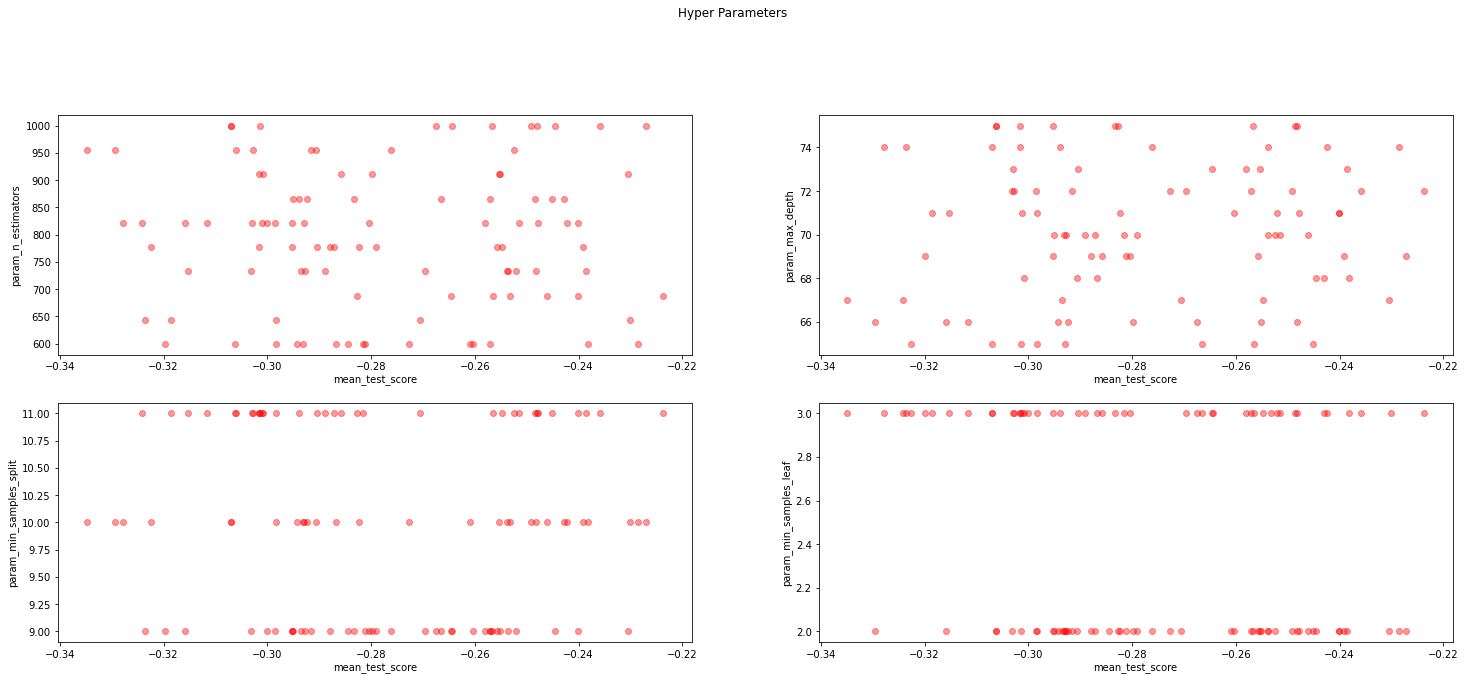

In [ ]:
# Plot the hypeparameters in relation of mean test score
# Values are plotted through dots. The brighter the dot, the more times that value has been chosen by the models.
# On the X axis, the closer the values are to 0 the better they are

h_params = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', ]
fig = plt.figure(figsize=(25, 15))
fig.suptitle('Hyper Parameters')
outer = gridspec.GridSpec(3, 2, wspace=0.2, hspace=0.2)
for index, h_param in enumerate(h_params):
    ax = plt.Subplot(fig, outer[index])
    ax.scatter(ris['mean_test_score'], ris[h_param], color='red', alpha=0.4, )
    ax.set_ylabel(h_param)
    ax.set_xlabel('mean_test_score')
    fig.add_subplot(ax)
fig.show()

## Feature Importance

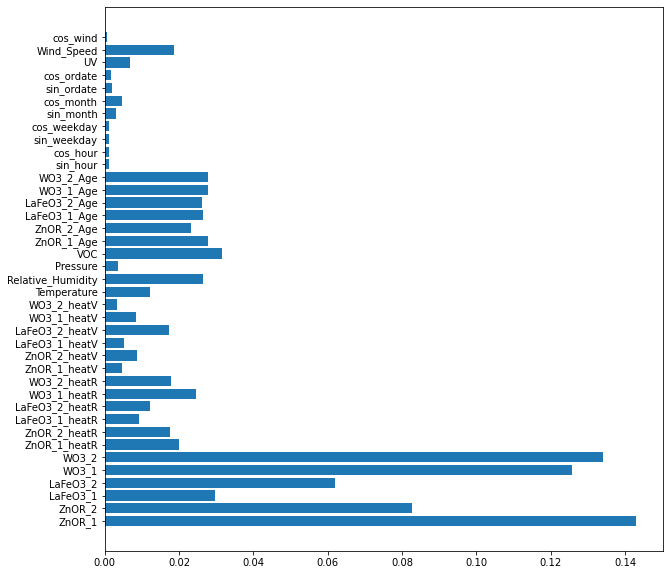

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.barh(X_test.columns, rf_random.best_estimator_.feature_importances_)
plt.show()